# Анализ убытков приложения ProcrastinatePRO+

### Описание проекта

Вы — маркетинговый аналитик развлекательного приложения Procrastinate Pro+. Несмотря на огромные вложения в рекламу, последние несколько месяцев компания терпит убытки. 

Задача — разобраться в причинах и помочь компании выйти в плюс.

Есть данные о пользователях, привлечённых с 1 мая по 27 октября 2019 года:

- лог сервера с данными об их посещениях,

- выгрузка их покупок за этот период,

- рекламные расходы.

### Описание данных
В вашем распоряжении три датасета. Файл visits_info_short.csv хранит лог сервера с информацией о посещениях сайта, orders_info_short.csv — информацию о заказах, а costs_info_short.csv — информацию о расходах на рекламу.

Структура visits_info_short.csv:
- User Id — уникальный идентификатор пользователя,
- Region — страна пользователя,
- Device — тип устройства пользователя,
- Channel — идентификатор источника перехода,
- Session Start — дата и время начала сессии,
- Session End — дата и время окончания сессии.

Структура orders_info_short.csv:
- User Id — уникальный идентификатор пользователя,
- Event Dt — дата и время покупки,
- Revenue — сумма заказа.

Структура costs_info_short.csv:
- dt — дата проведения рекламной кампании,
- Channel — идентификатор рекламного источника,
- costs — расходы на эту кампанию.

### План:
1. Загрузка данных и подготовка их к анализу
2. Функции для расчёта и анализа LTV, ROI, удержания и конверсии
3. Исследовательский анализ данных
4. Маркетинг
5. Оценка окупаемости рекламы
6. Вывод

### Загрузка данных и подготовка их к анализу

Загрузим данные о визитах, заказах и рекламных расходах из CSV-файлов в переменные.

Пути к файлам

- визиты: `/datasets/visits_info_short.csv`. [Скачать датасет](https://code.s3.yandex.net/datasets/visits_info_short.csv);
- заказы: `/datasets/orders_info_short.csv`. [Скачать датасет](https://code.s3.yandex.net/datasets/orders_info_short.csv);
- расходы: `/datasets/costs_info_short.csv`. [Скачать датасет](https://code.s3.yandex.net/datasets/costs_info_short.csv).

Изучим данные и выполним предобработку. Есть ли в данных пропуски и дубликаты? Убедимся, что типы данных во всех колонках соответствуют сохранённым в них значениям. Обратим внимание на столбцы с датой и временем.

In [1]:
import pandas as pd
import numpy as np 
from datetime import datetime, timedelta
from matplotlib import pyplot as plt

In [2]:
try:
    visits = pd.read_csv('/datasets/visits_info_short.csv')
except:
    visits = pd.read_csv('https://code.s3.yandex.net/datasets/visits_info_short.csv')
    
try:
    orders = pd.read_csv('/datasets/orders_info_short.csv')
except:
    orders = pd.read_csv('https://code.s3.yandex.net/datasets/orders_info_short.csv')
    
try:
    costs = pd.read_csv('/datasets/costs_info_short.csv')
except:
    costs = pd.read_csv('https://code.s3.yandex.net/datasets/costs_info_short.csv')

In [3]:
visits.columns = ['user_id', 'region', 'device', 'channel', 'session_start', 'session_end']
visits
orders.columns = ['user_id', 'event_dt', 'revenue']
orders
costs.rename(columns = {'Channel':'channel'}, inplace=True)
costs

visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])
orders['event_dt'] = pd.to_datetime(orders['event_dt'])
costs['dt'] = pd.to_datetime(costs['dt']).dt.date #дата проведения рекламной кампании

In [4]:
#visits.info() #нет пропусков
visits.duplicated().sum() #нет дубликатов
visits.isna().sum()

#orders.info() #нет пропусков
orders.duplicated().sum() #нет дубликатов
orders.isna().sum()

costs.info() #нет пропусков
costs.duplicated().sum() #нет дубликатов
costs.isna().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


dt         0
channel    0
costs      0
dtype: int64

,dt,channel,costs
682,2019-09-20,TipTop,535.5
683,2019-09-21,TipTop,514.5
684,2019-09-22,TipTop,616.0
685,2019-09-23,TipTop,570.5
686,2019-09-24,TipTop,556.5


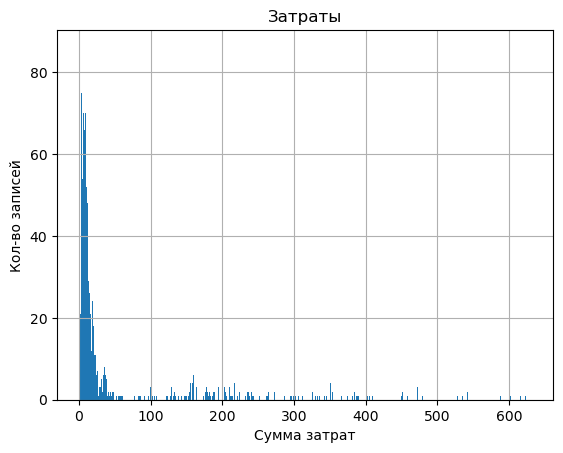

In [5]:
#visits.hist(bins=100)

#orders.hist(bins=100)
#orders['revenue'].hist(bins=10)
orders[orders['revenue'] > 40].count() #212
orders.query('revenue > 15 and revenue < 30').count() # 204

costs.hist(bins=1000)
plt.title('Затраты')
plt.ylabel('Кол-во записей')
plt.xlabel('Сумма затрат')

costs.query('costs > 500').head()



В датасете visits не было замечено выбросов.

В датасете orders так же нет выбросов, только в столбце с суммой заказов, есть несколько заказов выделяющихся от остальных, сложно сказать, что это выброс, так как возможно кто-то и купил больше остальных.

В датасете costs почти все значения приближены к 0, но так же достаточно значений распределено до 600, есть 17 больших расходов больше 500, не ясно ошибки ли это, так как возможно на этот канал и правда столько потрачено.

 - - После изучения данных была выполнена предобработка: изменены типы, проверены пропуски и дубликаты. 

### Функции для расчёта и анализа LTV, ROI, удержания и конверсии.



Функции для вычисления значений метрик:

- `get_profiles()` — для создания профилей пользователей,
- `get_retention()` — для подсчёта Retention Rate,
- `get_conversion()` — для подсчёта конверсии,
- `get_ltv()` — для подсчёта LTV.

А также функции для построения графиков:

- `filter_data()` — для сглаживания данных,
- `plot_retention()` — для построения графика Retention Rate,
- `plot_conversion()` — для построения графика конверсии,
- `plot_ltv_roi` — для визуализации LTV и ROI.

Функция для создания профилей пользователей

In [6]:
# функция для создания пользовательских профилей

def get_profiles(sessions, orders, costs):

    # находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    costs = costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    costs['acquisition_cost'] = costs['costs'] / costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles

Функция для подсчёта Retention Rate

In [7]:
# функция для расчёта удержания

def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 


Функция для подсчёта конверсии

In [8]:
# функция для расчёта конверсии

def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

Функция для подсчёта LTV

In [9]:
# функция для расчёта LTV и ROI

def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    ) 

Функции для построения графиков:

для сглаживания данных

In [10]:
# функция для сглаживания фрейма

def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df 

для построения графика Retention Rate

In [11]:
# функция для визуализации удержания

def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

для построения графика конверсии

In [12]:
# функция для визуализации конверсии

def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 


для визуализации LTV и ROI

In [13]:
# функция для визуализации LTV и ROI

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 

### Исследовательский анализ данных


- Составим профили пользователей. Определим минимальную и максимальную даты привлечения пользователей.

In [14]:
profiles = get_profiles(visits, orders, costs)
print(profiles.sort_values(by='first_ts')) 

             user_id            first_ts             channel   device  \
57600   382394863972 2019-05-01 00:00:41        MediaTornado      Mac   
64627   428935481941 2019-05-01 00:01:35          AdNonSense       PC   
13003    86266511938 2019-05-01 00:02:38             organic  Android   
114484  763000657462 2019-05-01 00:04:21             organic       PC   
118717  791058813280 2019-05-01 00:05:17             LeapBob  Android   
...              ...                 ...                 ...      ...   
89975   598664469855 2019-10-27 23:55:23          AdNonSense   iPhone   
2740     18615786610 2019-10-27 23:55:42             organic  Android   
64788   430005587232 2019-10-27 23:56:13  OppleCreativeMedia       PC   
52833   350809890323 2019-10-27 23:58:24              TipTop   iPhone   
111023  739432831998 2019-10-27 23:59:04              TipTop   iPhone   

               region          dt      month  payer  acquisition_cost  
57600   United States  2019-05-01 2019-05-01  False

Минимальная дата - 2019-05-01

Максимальная дата - 2019-10-27

Результат — 150008 пользовательских профилей, в каждом из которых есть данные о дате первого посещения и рекламном источнике, который мотивировал пользователя. 

- Выясним, из каких стран пользователи приходят в приложение и на какую страну приходится больше всего платящих пользователей. Построим таблицу, отражающую количество пользователей и долю платящих из каждой страны.

               payer   part_of
region                        
United States   6108  0.065278
UK               569  0.006081
France           554  0.005921
Germany          490  0.005237


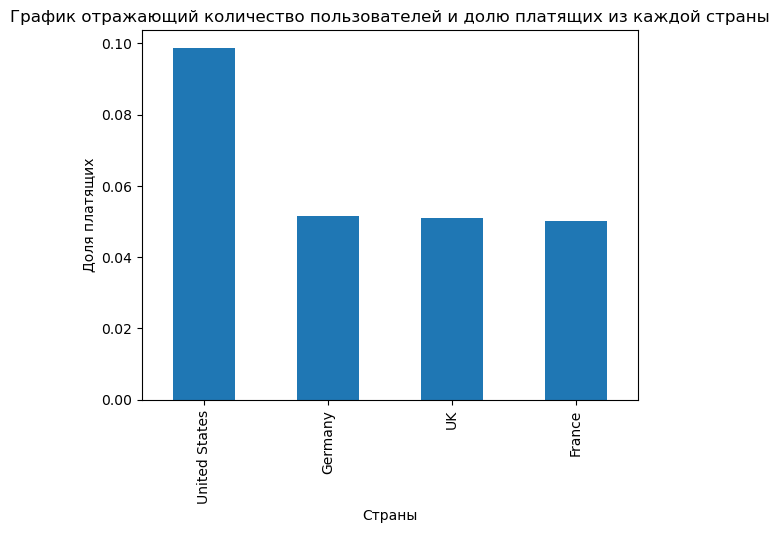

In [28]:
region_payer = profiles.query('payer == True').groupby('region').agg({'payer': 'count'}).sort_values(by='payer', ascending=False)
region_payer['part_of'] = region_payer['payer'] / (profiles['payer'].count())
print(region_payer)

def paying_part(characteristic):
    paying = profiles\
    .pivot_table(index=characteristic, values=['user_id', 'payer'],\
             aggfunc={'user_id':'count', 'payer':'sum'})

    paying.columns = ['payer_count' ,'all_users']
    paying['paying_ratio'] =\
    (paying['payer_count'] / paying['all_users']).round(4)
    paying = paying.sort_values(by='paying_ratio', ascending=False)
    paying['paying_ratio'].plot(kind='bar')
    return paying.sort_values(by='paying_ratio', ascending=False)
paying_part('region')

plt.title('График отражающий количество пользователей и долю платящих из каждой страны')
plt.ylabel('Доля платящих')
plt.xlabel('Страны')
plt.show()

Больше всего платящих в United States и по доле от общего числа пользователей и от общего числа платящих в этой стране.

- Узнаем, какими устройствами пользуются клиенты и какие устройства предпочитают платящие пользователи. Построим таблицу, отражающую количество пользователей и долю платящих для каждого устройства.

         payer   part_of
device                  
iPhone    2972  0.031763
Android   1782  0.019045
Mac       1673  0.017880
PC        1294  0.013829


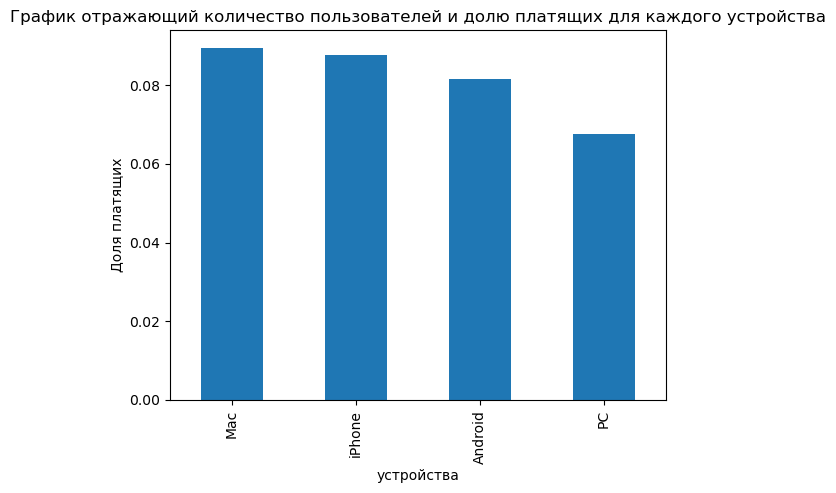

In [29]:
device_payer = profiles.query('payer == True').groupby('device').agg({'payer': 'count'}).sort_values(by='payer', ascending=False)
device_payer['part_of'] = device_payer['payer'] / (profiles['payer'].count())
print(device_payer)

def paying_part(characteristic):
    paying = profiles\
    .pivot_table(index=characteristic, values=['user_id', 'payer'],\
             aggfunc={'user_id':'count', 'payer':'sum'})

    paying.columns = ['payer_count' ,'all_users']
    paying['paying_ratio'] =\
    (paying['payer_count'] / paying['all_users']).round(4)
    paying = paying.sort_values(by='paying_ratio', ascending=False)
    paying['paying_ratio'].plot(kind='bar')
    return paying.sort_values(by='paying_ratio', ascending=False)
paying_part('device')

plt.title('График отражающий количество пользователей и долю платящих для каждого устройства')
plt.ylabel('Доля платящих')
plt.xlabel('устройства')
plt.show()

Клиенты пользуются iPhone, Android, Mac, PC. Больше всего платящих пользователей у iPhone, если смотреть от общего числа, если от числа общего по устройству то больше доля платящи у Mac.

- Изучим рекламные источники привлечения и определите каналы, из которых пришло больше всего платящих пользователей. Построим таблицу, отражающую количество пользователей и долю платящих для каждого канала привлечения.

                    payer   part_of
channel                            
FaceBoom             3557  0.038015
TipTop               1878  0.020071
WahooNetBanner        453  0.004841
AdNonSense            440  0.004702
RocketSuperAds        352  0.003762
LeapBob               262  0.002800
OppleCreativeMedia    233  0.002490
lambdaMediaAds        225  0.002405
YRabbit               165  0.001763
MediaTornado          156  0.001667


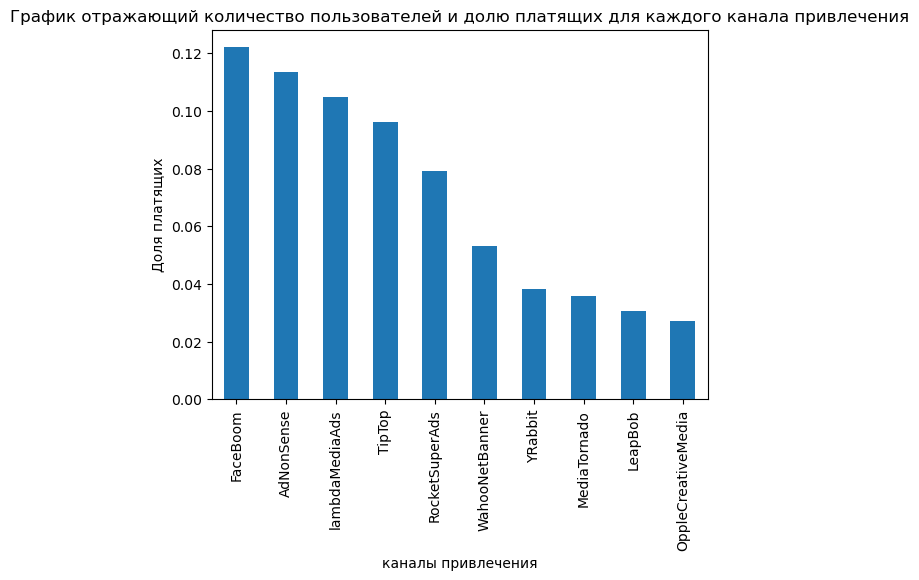

In [30]:
channel_payer = profiles.query('payer == True').groupby('channel').agg({'payer': 'count'}).sort_values(by='payer', ascending=False)
channel_payer['part_of'] = channel_payer['payer'] / (profiles['payer'].count())
print(channel_payer)

def paying_part(characteristic):
    paying = profiles\
    .pivot_table(index=characteristic, values=['user_id', 'payer'],\
             aggfunc={'user_id':'count', 'payer':'sum'})

    paying.columns = ['payer_count' ,'all_users']
    paying['paying_ratio'] =\
    (paying['payer_count'] / paying['all_users']).round(4)
    paying = paying.sort_values(by='paying_ratio', ascending=False)
    paying['paying_ratio'].plot(kind='bar')
    return paying.sort_values(by='paying_ratio', ascending=False)
paying_part('channel')

plt.title('График отражающий количество пользователей и долю платящих для каждого канала привлечения')
plt.ylabel('Доля платящих')
plt.xlabel('каналы привлечения')
plt.show()

Если смотреть от общего числа пользователей, то из рекламных источников FaceBoom, TipTop, organic пришло больше всего платящих пользователей. Если от общего числа пользователей от конкретного источника, то FaceBoom, AdNonSense, lambdaMediaAds, TipTop.

### Маркетинг


- Посчитаем общую сумму расходов на маркетинг.

In [18]:
profiles['acquisition_cost'].sum()


105497.29999999999

- Выясним, как траты распределены по рекламным источникам, то есть сколько денег потратили на каждый источник.

In [19]:
acquisition = profiles.groupby('channel').agg({'acquisition_cost': 'sum'}).sort_values(by='acquisition_cost', ascending=False)
print(acquisition)

                    acquisition_cost
channel                             
TipTop                      54751.30
FaceBoom                    32445.60
WahooNetBanner               5151.00
AdNonSense                   3911.25
OppleCreativeMedia           2151.25
RocketSuperAds               1833.00
LeapBob                      1797.60
lambdaMediaAds               1557.60
MediaTornado                  954.48
YRabbit                       944.22
organic                         0.00


Больше всего траты на рекламные источники:TipTop, FaceBoom.

- Построим визуализацию динамики изменения расходов во времени (по неделям и месяцам) по каждому источнику. Постараемся отразить это на одном графике.

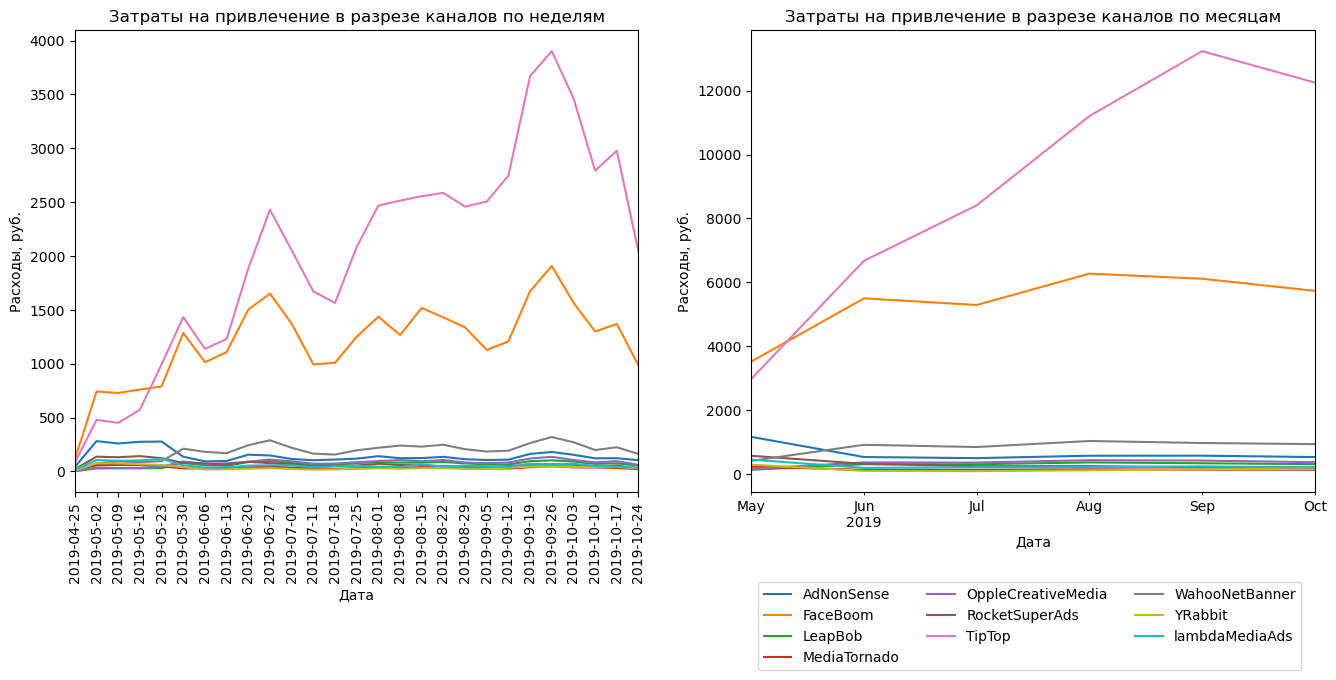

In [20]:
costs_channel = costs.groupby(['dt', 'channel']).agg({'costs': 'sum'})\
                  .sort_values(by=['dt', 'costs'], ascending=False)

costs['week_dt'] = costs['dt'].astype('datetime64[W]')
costs['month_dt'] = costs['dt'].astype('datetime64[M]')

# построим график ежедневных затрат по каналам. Код, который позволит расположить два графика рядом и который сделает одну легенду
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

(costs
 .pivot_table(
    index=costs.week_dt,
    values='costs',
    aggfunc='sum',
    columns='channel'
)
 .plot(ax=ax[0], legend=False)
)

ax[0].set_xticks(costs.week_dt.dt.date.unique())
ax[0].set_xticklabels(costs.week_dt.dt.date.unique(), rotation=90)
ax[0].set_title('Затраты на привлечение в разрезе каналов по неделям', loc='center')
ax[0].set_ylabel('Расходы, руб.')
ax[0].set_xlabel('Дата')

(costs
 .pivot_table(
    index=costs.month_dt,
    values='costs',
    aggfunc='sum',
    columns='channel'
)
 .plot(ax=ax[1])
)

ax[1].set_title('Затраты на привлечение в разрезе каналов по месяцам', loc='center')
ax[1].set_ylabel('Расходы, руб.')
ax[1].set_xlabel('Дата')
ax[1].legend(ncol=3, bbox_to_anchor=(0, -0.4), loc='lower left')
plt.show()


По графикам видно, что явно выделяются расходы на TipTop и FaceBoom. Особенно расходы выросли в под конец периода в августе-сентябре-октябре. Тоже самое видим по недельному графику.  

- Узнаем, сколько в среднем стоило привлечение одного пользователя (CAC) из каждого источника. Используем профили пользователей.

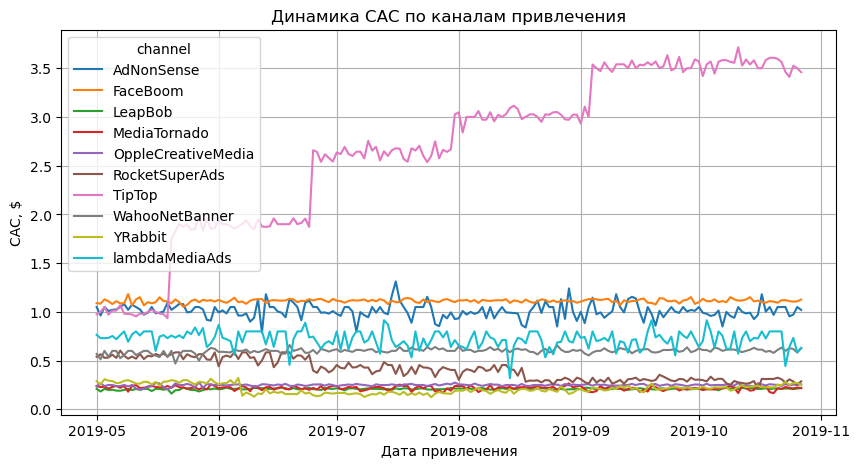

                    acquisition_cost
channel                             
TipTop                      2.799003
FaceBoom                    1.113286
AdNonSense                  1.008054
lambdaMediaAds              0.724802
WahooNetBanner              0.602245
RocketSuperAds              0.412095
OppleCreativeMedia          0.250000
YRabbit                     0.218975
MediaTornado                0.218717
LeapBob                     0.210172
средний CAC для всего проекта: 0.7032778251827625


In [21]:
profiles = profiles.query('channel != "organic"')

cac = get_profiles(visits, orders, costs)
user_cac = cac.query('channel != "organic"').groupby(['channel']).agg({'acquisition_cost': 'mean'}).sort_values(by='acquisition_cost', ascending=False)

profiles.pivot_table(
    index='dt', columns='channel', values='acquisition_cost', aggfunc='mean'
).plot(grid=True, figsize=(10, 5))
plt.ylabel('CAC, $')
plt.xlabel('Дата привлечения')
plt.title('Динамика САС по каналам привлечения')
plt.show()


all_cac = cac['acquisition_cost'].mean()
print(user_cac)

print(f'средний CAC для всего проекта: {all_cac}')

Дороже всего стоило привлечение в TipTop. Дальше примерно одинаково стоило FaceBoom и AdNonSense. По графику видим постепенное увеличение цены к концу периода у TipTop. 

### Оценка окупаемости рекламы


In [22]:
observation_date = datetime(2019, 11, 1).date()  # момент анализа
horizon_days = 14  # горизонт анализа 

- Проанализируем окупаемость рекламы c помощью графиков LTV и ROI, а также графики динамики LTV, CAC и ROI.

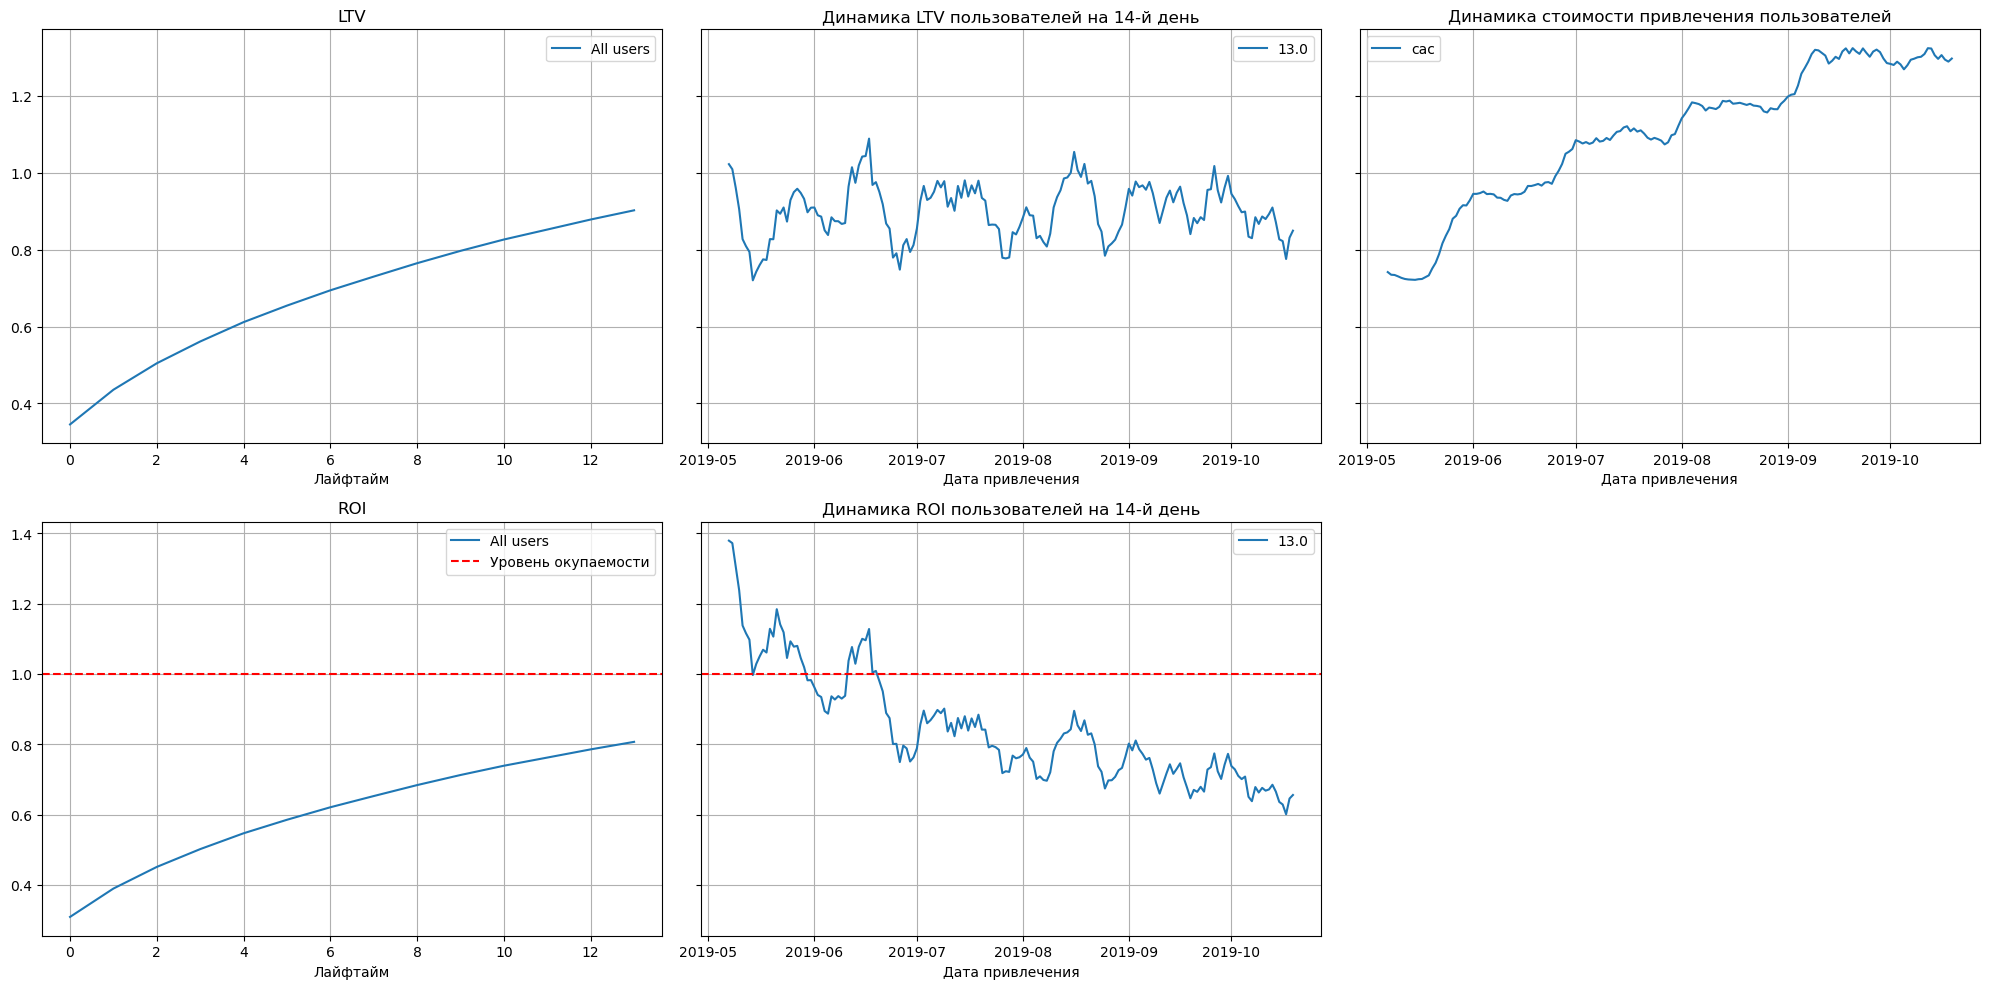

In [23]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days
)

# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days)

По общим графикам видим: 

По графику LTV, что сумма денег которую приносит клиент в общем растет.

Так же видим, что стоимость привелечение САС растет.

ПО графику ROI, видим что до уровня окупаемости так же не дотягиваем.

По графику динами ROI на 14 день видим что окупаемость начала падать.

- Проверим конверсию пользователей и динамику её изменения. То же самое сделаем с удержанием пользователей. Построим и изучим графики конверсии и удержания.

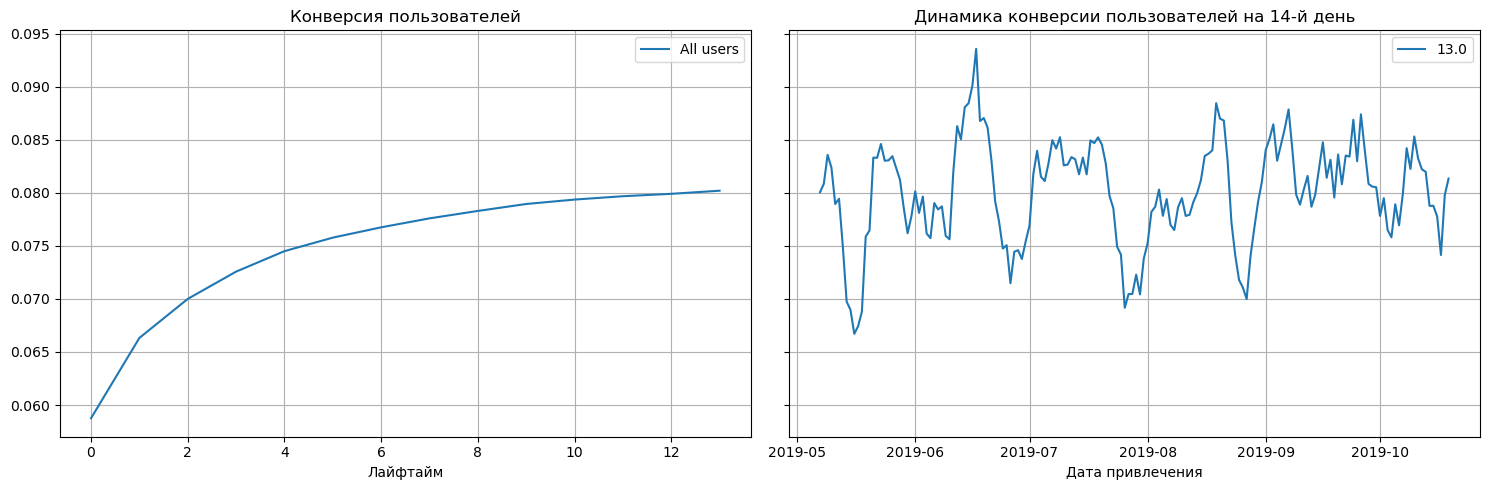

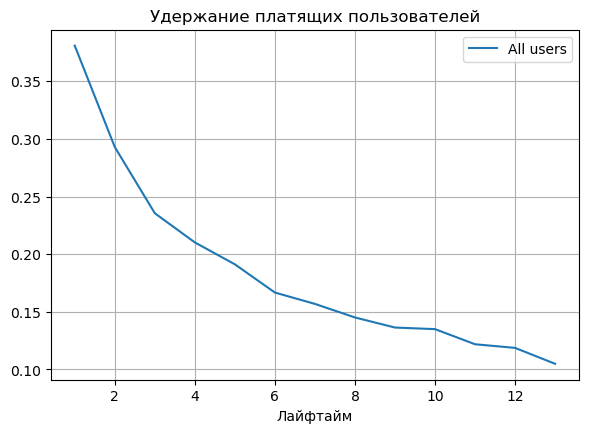

In [24]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

# смотрим удержание 

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days
)

plot_retention(retention_grouped, retention_history, horizon_days) 

По графику конверсии видим, что конверсия пользователей расет.

По графику удержания видим, что удержание пользователей падает.

- Проанализируем окупаемость рекламы с разбивкой по устройствам. Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.

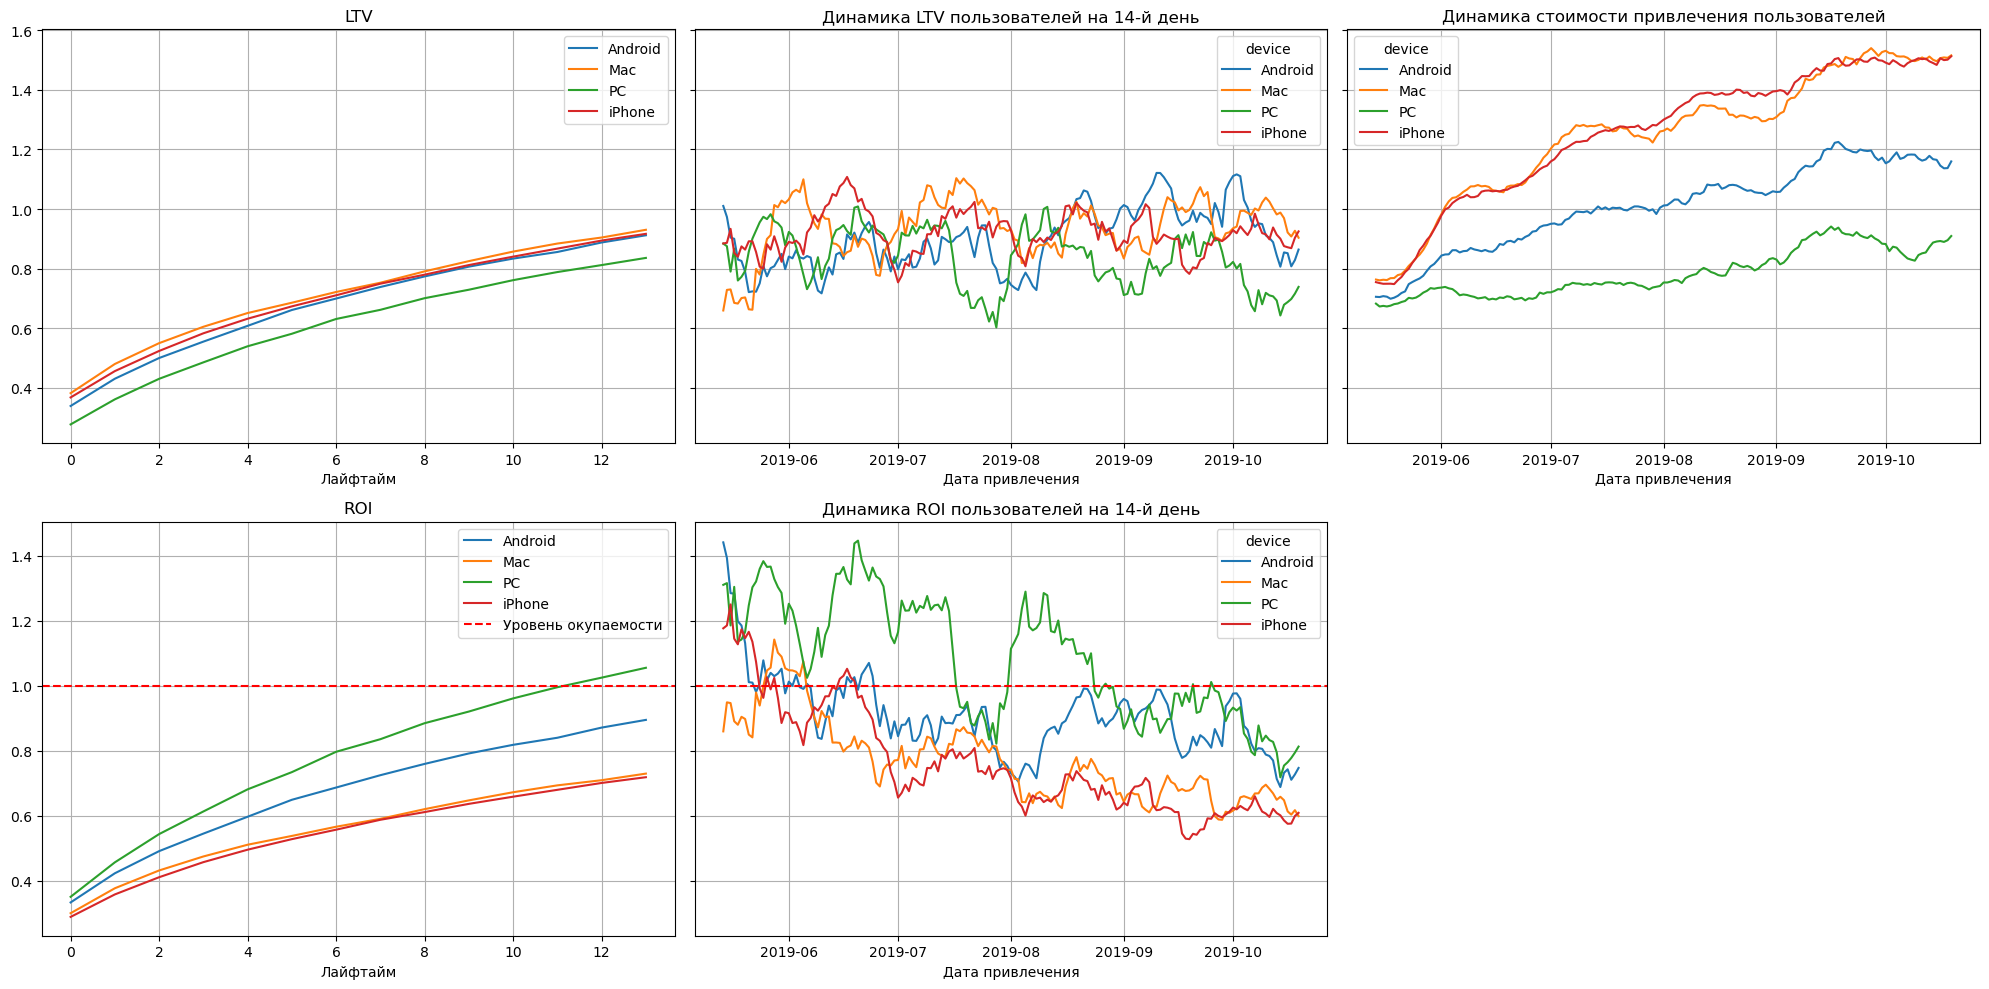

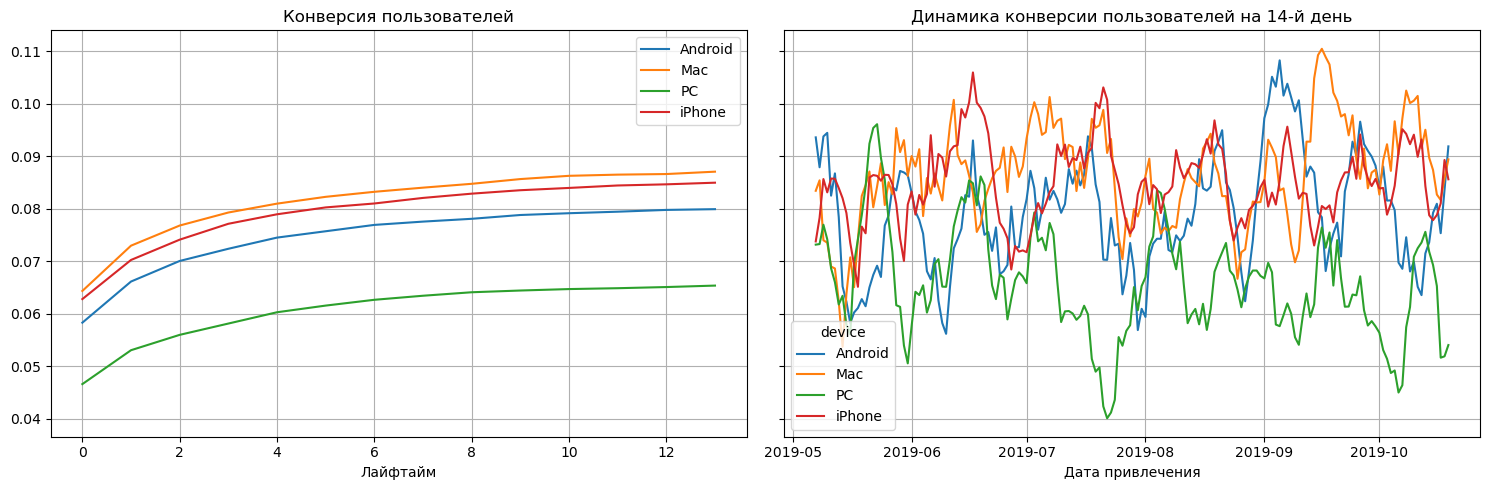

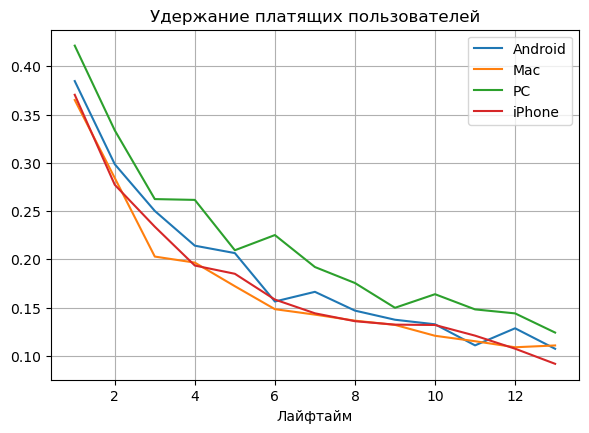

In [25]:
# смотрим окупаемость с разбивкой по устройствам

dimensions = ['device']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
)

# смотрим конверсию с разбивкой по устройствам

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

# смотрим удержание с разбивкой по устройствам

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

По графикам видим, что пользователи PC окупаются, а пользователи остальных устройств нет. При это по графику конверсии видим что пользователи PC конвертируются немного хуже остальных, но при этом график удержания у PC немного лучше остальных.

- Проанализируем окупаемость рекламы с разбивкой по странам. Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI

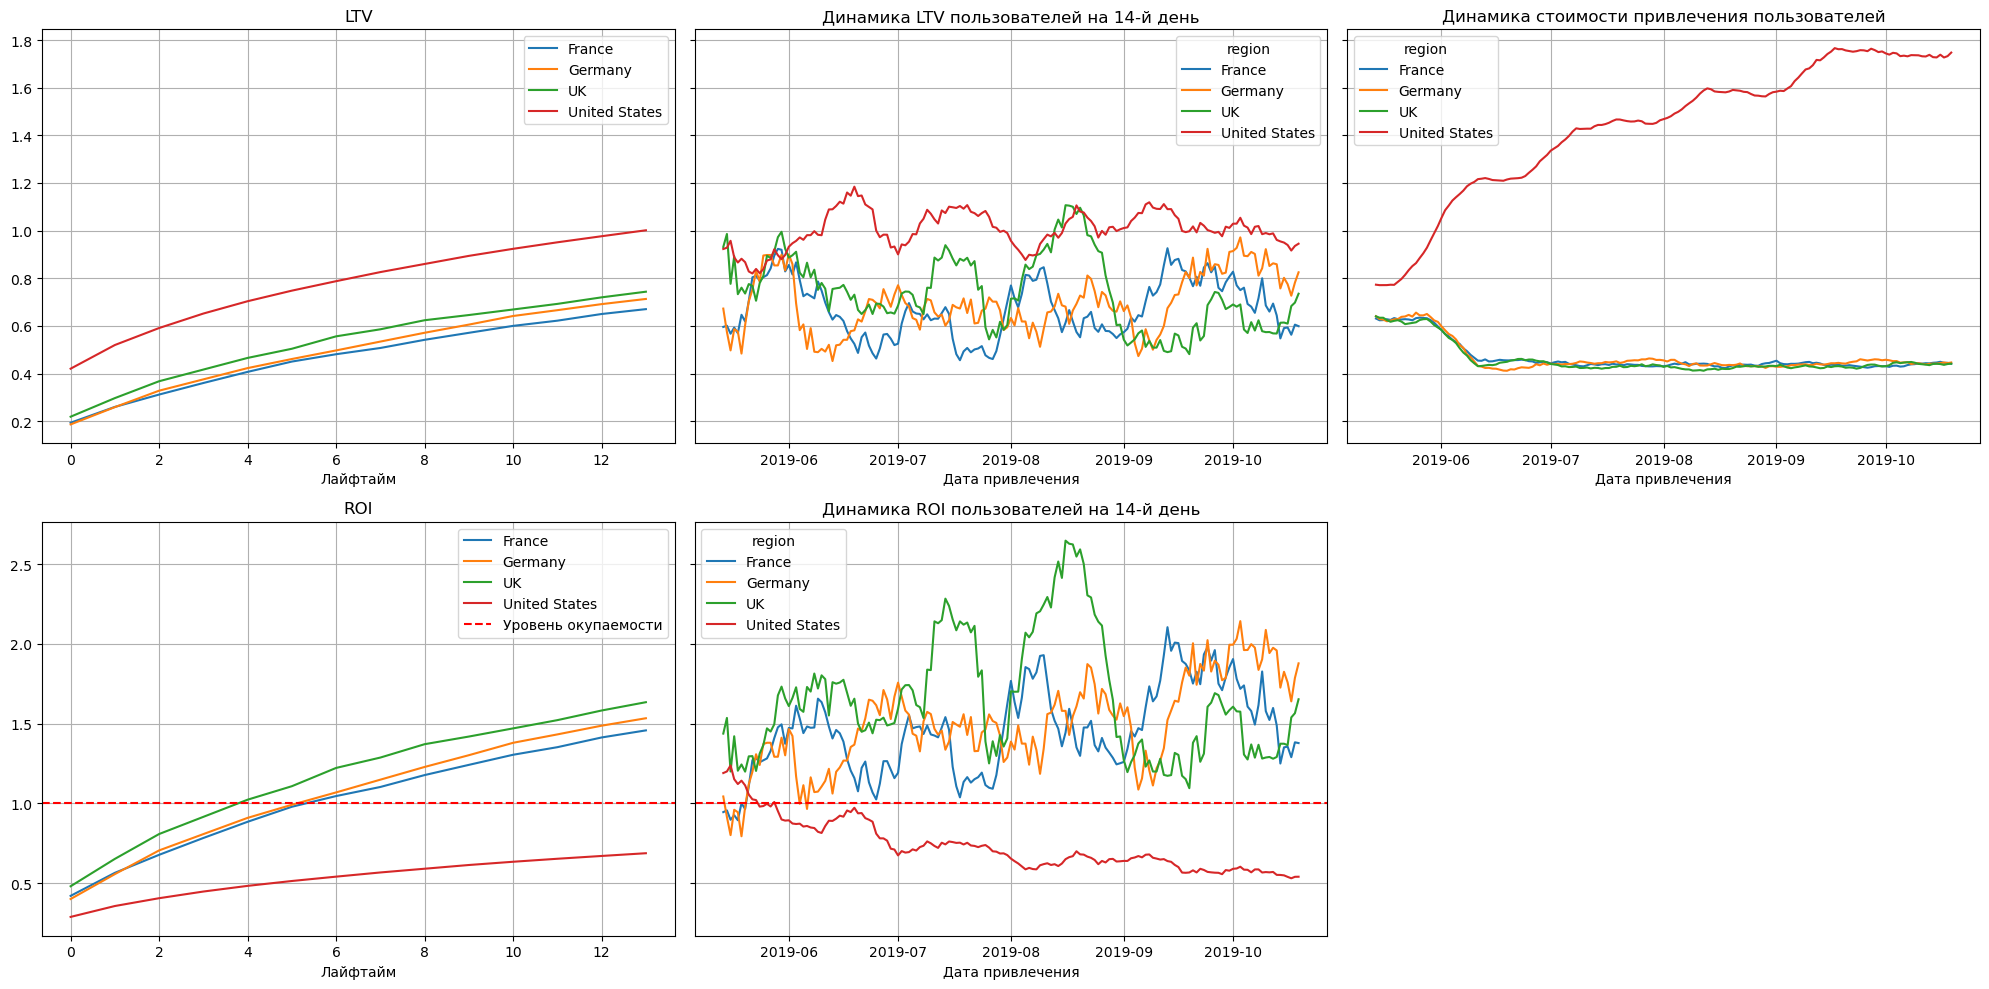

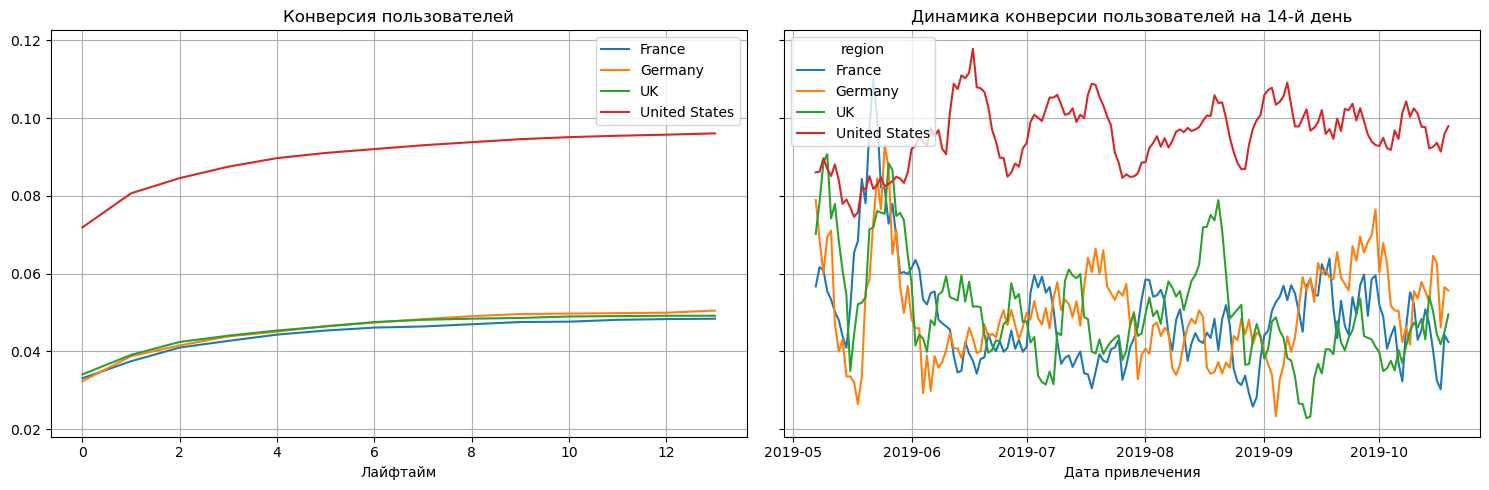

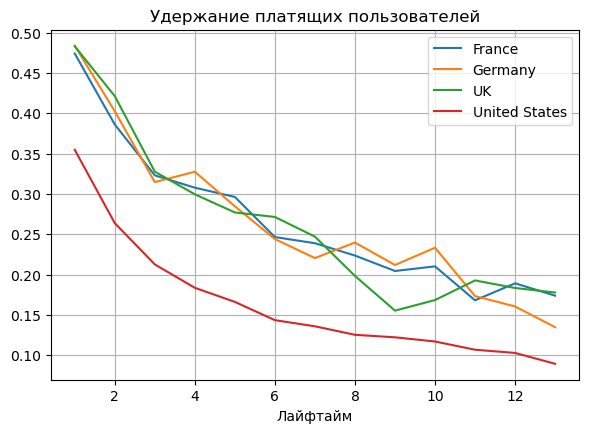

In [26]:
# смотрим окупаемость с разбивкой по странам

dimensions = ['region']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

# смотрим конверсию с разбивкой по странам

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

# смотрим удержание с разбивкой по странам

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

По графикам видим, что окупаются все страны кроме United States. При этом и стоимость привлечения в этой стране растет.
По графику конверсии видим что пользователи US конвертируются хорошо, в то же время график удержания US хуже по сравнению с остальными странами.

- Проанализируем окупаемость рекламы с разбивкой по рекламным каналам. Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.

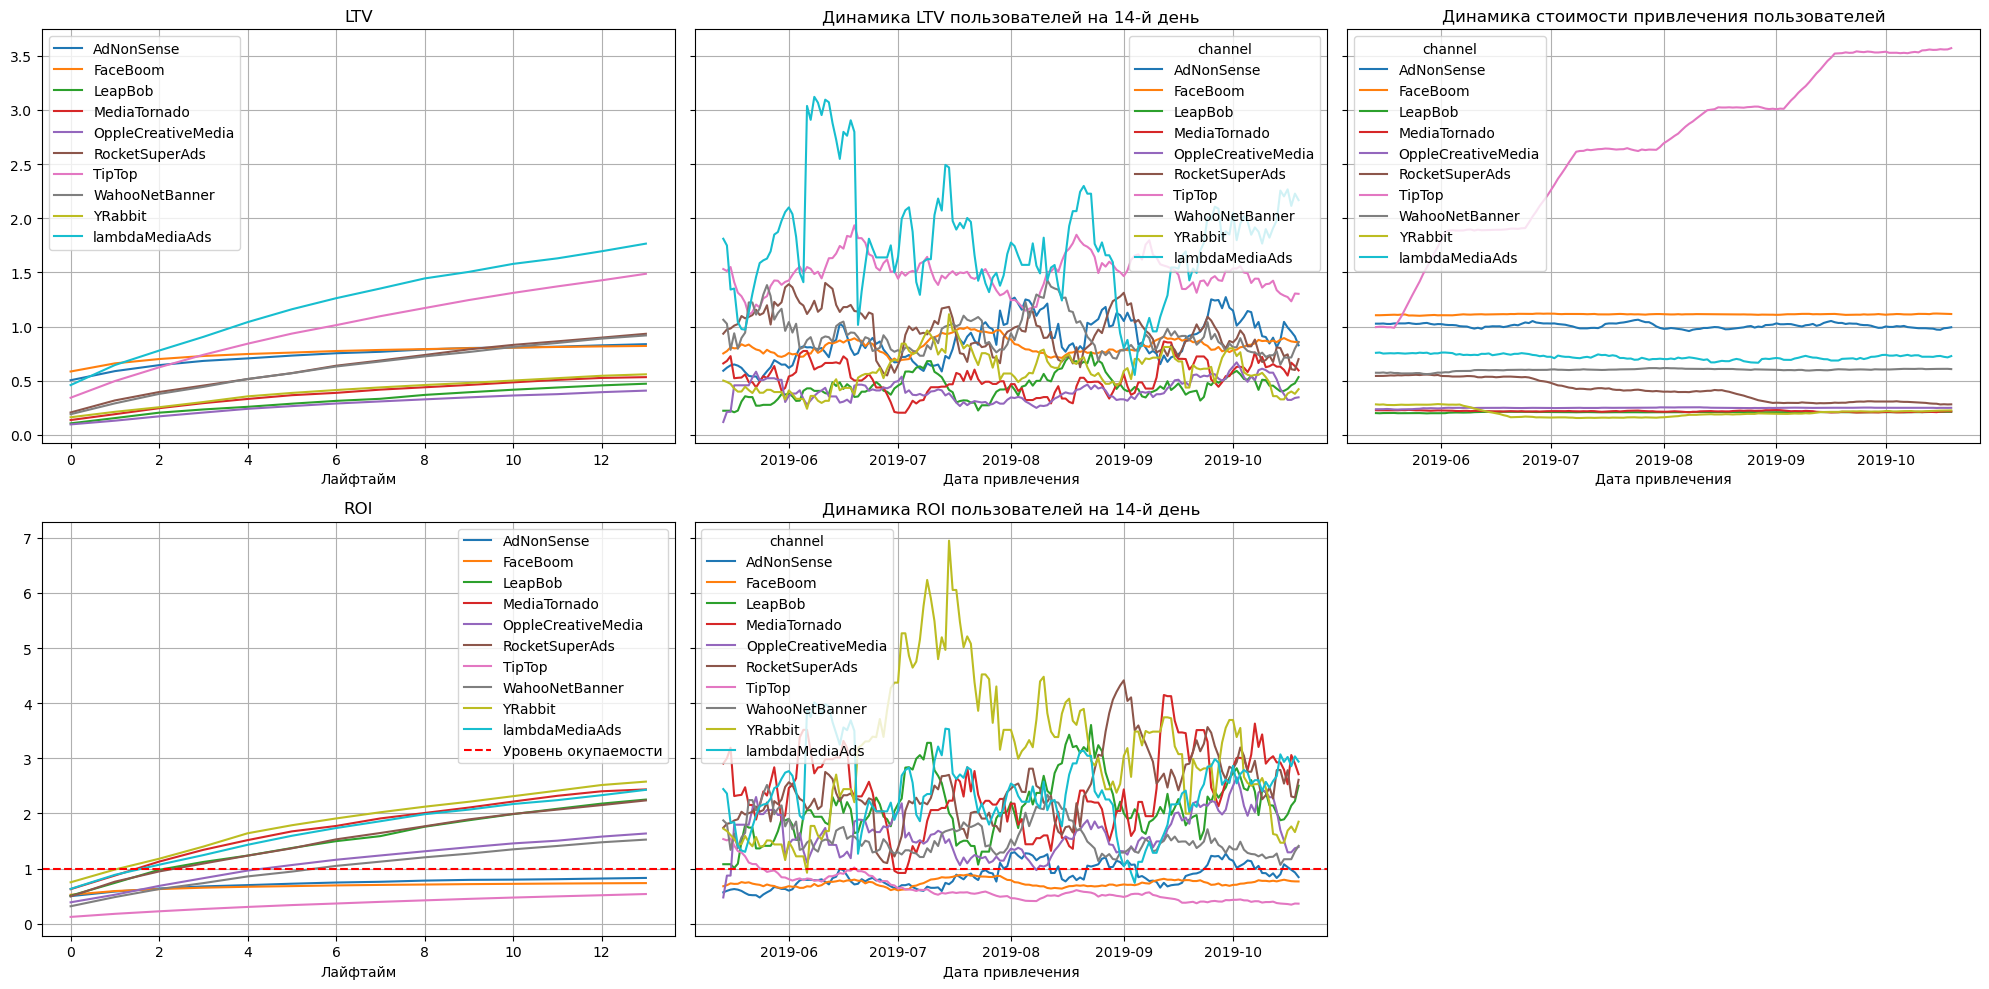

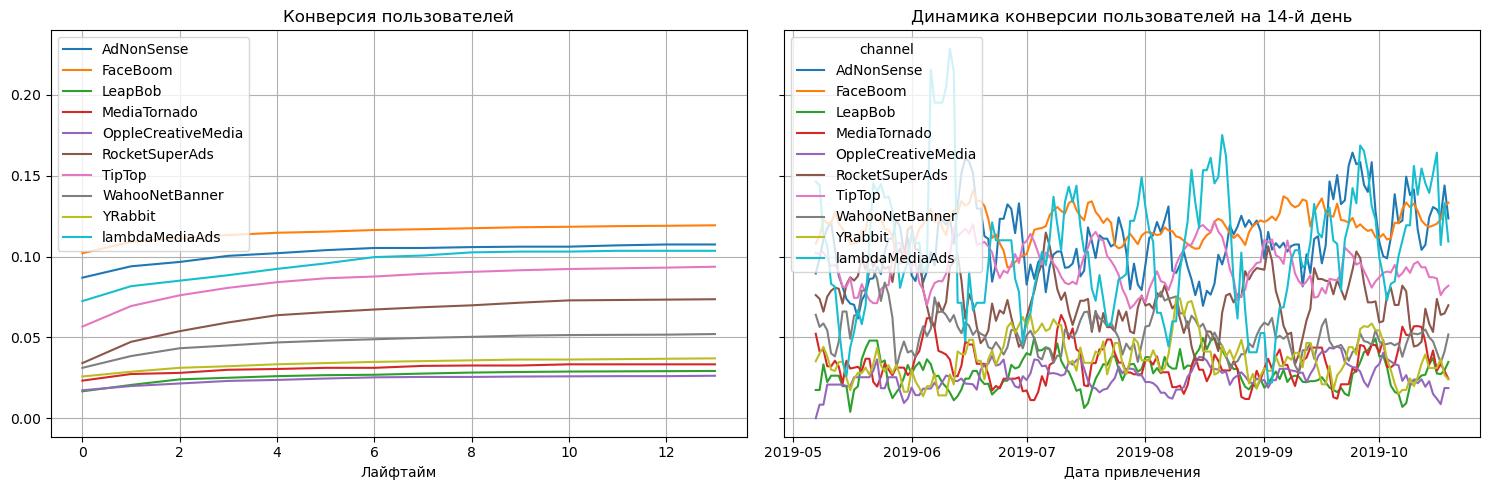

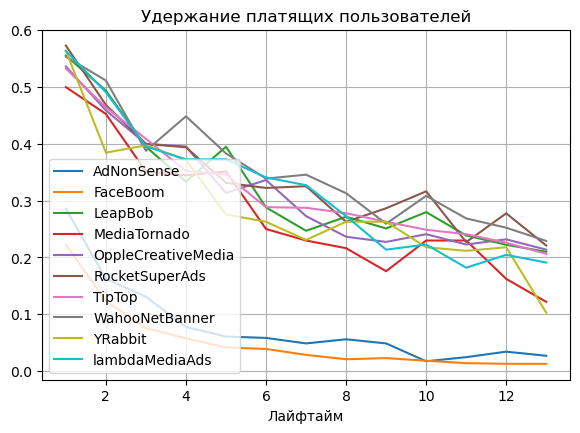

In [27]:
# смотрим окупаемость с разбивкой по источникам привлечения

dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
)

# смотрим конверсию с разбивкой по источникам привлечения

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

# смотрим удержание с разбивкой по источникам привлечения

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

По графикам видно, что AdNonSense, FaceBoom, TipTop не окупаются. При этом стоимость привлечения в TipTop кардинально выше остальных. Есть подозрения что эти каналы как раз из United States.

Графики конверсии и удержания подтвержают подозрения, каналы AdNonSense и FaceBoom хорошо конвертируются, но пользователи дольше одной покупки не остаются.

### Выводы



  - Окупается ли реклама, направленная на привлечение пользователей в целом?
    
    Нет, в целом, реклама не окупается.
    
    
  - Какие устройства, страны и рекламные каналы могут оказывать негативное влияние на окупаемость рекламы?
    
    Устройства: все устройства, кроме PC.
    
    Страны: United States.
    
    Рекламные каналы: AdNonSense, FaceBoom, TipTop.
    
    
  - Чем могут быть вызваны проблемы окупаемости?
    
    Скорее всего все рекламные каналы и устройства связаны со страной из которых они - United States.
    Возможно, наш продукт плохо заходит аудитории оттуда, либо это связанос неправильными выбранными каналами так как стоимость этих каналов выше чем остальных и чтобы они окупались нужно больше платящих пользователей, даже при том что из этих каналов их больше всего. С устройствами может быть связано так же так как Устройства Apple популярнее всего в United States.

Причины:

-Неэффектиный выбор и использование некоторых каналов привлечения, а именно AdNonSense и TipTop, конвертация которых находится на высоком уровне, но удерживание пользователей, по сравнению с остальными каналами, хуже всего.

-В следствии чего из каналов AdNonSense и TipTop пользователи приходят на один раз, не совершая повторные покупки.

Рекомендации:

-Отказ от не целевых каналов, переориентирование на каналы с более подходящей аудиторией.
